In [1]:
from funcs import * # funcs include functions used across scripts
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import datetime as dt

read the .ict data

In [2]:
o = read_all('OPTICAL') # optical data
inl = read_all('InletFlag') # inlet flag
a = read_all('AMS') # ams
mn = read_all('MetNav') # met nav

In [3]:
ams_keys = ['Org_Ave_IsoK_STP','SO4_Ave_IsoK_STP','NO3_Ave_IsoK_STP','NH4_Ave_IsoK_STP','Chl_Ave_IsoK_STP']
a['tot'] = a[ams_keys].sum(axis=1)
a = a[a['tot']>.4]
a['OMF'] = a['Org_Ave_IsoK_STP']/a['tot']
a['SMF'] = a['SO4_Ave_IsoK_STP']/a['tot']

read the DASH data

In [4]:
retrieval_paths = sorted(glob.glob('../data/v2/*/*/*.csv'))
retrieval_list = []
for i in range(0, len(retrieval_paths)):
    retrieval_list.append(pd.read_csv(retrieval_paths[i], parse_dates=['Start_Date_Time_UTC', 'Stop_Date_Time_UTC']))
r = pd.concat(retrieval_list).reset_index(drop=True)

Separate data by size

In [5]:
r_dps = []
dps = sorted(r['SEMS_Dp'].unique())
for i in range(0,len(dps)):
    r_dps.append(r[(r['RH']>75) & (r['SEMS_Dp']==dps[i])])

In [6]:
def merge_df_avg(df1, df2, st1 = 'Start_Date_Time_UTC', et1 = 'Stop_Date_Time_UTC', st2 = 'Time_Start', et2 = 'Time_Start', keys = ['GPS_Altitude']):
    
    def process_row(i):
        row = df1.iloc[i]
        t_start, t_stop = row[st1], row[et1]
        return df2[(df2[st2] >= t_start) & (df2[et2] <= t_stop)].mean(numeric_only=True)

    out = Parallel(n_jobs=-1)(delayed(process_row)(i) for i in tqdm(range(0, len(df1))))

    df_out = pd.DataFrame(out)
    df1.loc[:,keys] = df_out.loc[:,keys]
    return df1

In [7]:
def merge_df(df1, df2,left_on='Start_Date_Time_UTC', right_on='Time_Start', keys=['GPS_Altitude'], tolerance=pd.Timedelta("1s")):
    if right_on not in keys:
        keys.insert(0, right_on)
    return pd.merge_asof(df1, df2.loc[:,keys], left_on=left_on, right_on=right_on, tolerance=tolerance)

In [8]:
a = merge_df(a,mn,left_on='Time_Start')
o = merge_df(o,mn,left_on='Time_Mid')

Rename variables so they have size in name and add GPS altitude

In [9]:
for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    r_dps[i] = merge_df(r_dps[i], mn)

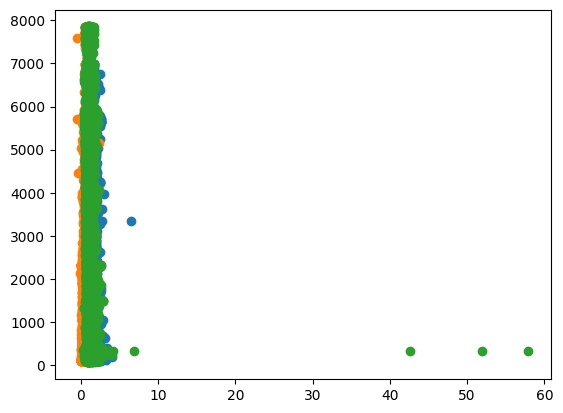

In [11]:
plt.scatter(r_dps[3]['GF_raw_200'], r_dps[3]['GPS_Altitude'])
plt.scatter(a['OMF'], a['GPS_Altitude'])
plt.scatter(o['fRH550_RH20to80'], o['GPS_Altitude'])

Merge data so it is only during sampling times

In [10]:
for i in range(0, len(dps)):
    d_label = str(int(dps[i]))
    r_dps[i] = r_dps[i].rename(columns={'GF_raw':'GF_raw_'+d_label})
    r_dps[i] = merge_df_avg(r_dps[i], o, keys=['fRH550_RH20to80'])
    r_dps[i] = merge_df(r_dps[i], a, right_on='Time_Mid', keys=['OMF', 'SMF'], tolerance = pd.Timedelta("30s"))

100%|██████████| 10/10 [00:00<00:00, 7231.56it/s]


**^RUN ABOVE CODE TO READ AND MERGE DATA^**

In [15]:
max_alt, min_alt = np.linspace(500,7000, 14), np.linspace(0,6500, 14)
GF_labels = ((max_alt+min_alt)/2).astype(int)
min_dt, max_dt = [pd.to_datetime('2024-5-28'), pd.to_datetime('2024-6-06'), pd.to_datetime('2024-7-29')], [pd.to_datetime('2024-6-01'),pd.to_datetime('2024-6-14'), pd.to_datetime('2024-8-10')]
titles = ['RF 1-3', 'RF 6-10', 'RF 11-18']
for i in range(0, len(dps)):
    D = dps[i]
    fig, ax = plt.subplots(1,3,sharey=True, sharex=True)
    fig.suptitle('D$_p$ = ' + str(int(D)))
    for j in range(0,3):
        sub = r_dps[i][(r_dps[i]['Start_Date_Time_UTC']>min_dt[j]) & (r_dps[i]['Start_Date_Time_UTC']<max_dt[j])]

        GF_len = []
        GF = []
        for k in range(0, len(min_alt)):
            GF.append(sub['GF_raw_'+str(int(D))][(sub['GPS_Altitude'] >= min_alt[k]) & (sub['GPS_Altitude'] < max_alt[k])].dropna())
            GF_len.append(len(GF[k]))
        ax[j].axvline(1, ls='--', c='black', alpha=.2)
        
        ax[j].set_title(titles[j])
        ax[j].boxplot(GF, tick_labels=GF_labels, vert = False, showfliers=False)
    ax[1].set_xlabel('GF')
    fig.savefig('../figures/alt_v_gf_overview_' + str(int(D)) +'.png', dpi=300)
    plt.close()

In [16]:
def plot_alt(variable):
    max_alt, min_alt = np.linspace(500,7000, 14), np.linspace(0,6500, 14)
    GF_labels = ((max_alt+min_alt)/2).astype(int)
    min_dt, max_dt = [pd.to_datetime('2024-5-28'), pd.to_datetime('2024-6-06'), pd.to_datetime('2024-7-29')], [pd.to_datetime('2024-6-01'),pd.to_datetime('2024-6-14'), pd.to_datetime('2024-8-10')]
    titles = ['RF 1-3', 'RF 6-10', 'RF 11-18']
    for i in range(0, len(dps)):
        D = dps[i]
        fig, ax = plt.subplots(1,3,sharey=True, sharex=True)
        fig.suptitle('D$_p$ = ' + str(int(D)))
        for j in range(0,3):
            sub = r_dps[i][(r_dps[i]['Start_Date_Time_UTC']>min_dt[j]) & (r_dps[i]['Start_Date_Time_UTC']<max_dt[j])]

            GF_len = []
            GF = []
            for k in range(0, len(min_alt)):
                GF.append(sub[variable][(sub['GPS_Altitude'] >= min_alt[k]) & (sub['GPS_Altitude'] < max_alt[k])].dropna())
                GF_len.append(len(GF[k]))
            
            ax[j].set_title(titles[j])
            ax[j].boxplot(GF, tick_labels=GF_labels, vert = False, showfliers=False)
        ax[1].set_xlabel(variable)
        fig.savefig('../figures/alt_v_'+variable+'_overview_' + str(int(D)) +'.png', dpi=300)
        plt.close()

In [17]:
plot_alt('OMF')

In [18]:
plot_alt('SMF')

In [19]:
plot_alt('fRH550_RH20to80')

In [20]:
def add_line(x,y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    m , b = np.polyfit(x_clean, y_clean, 1)
    x2 = np.linspace(x.min(), x.max(), 1000)
    y2 = x2*m + b
    return x2,y2, m, b

In [21]:
def plot_scatter(retrieval_variable, variable):
    for i in range(0, len(r_dps)):
        
        D = str(int(r_dps[i].loc[0,'SEMS_Dp']))
        fig, ax = plt.subplots()
        if retrieval_variable == 'GF':
            x,y = r_dps[i][variable], r_dps[i]['GF_raw_'+D]
        else:
            x,y = r_dps[i][variable], r_dps[i][retrieval_variable]
        ax.scatter(x,y, s=.5, alpha=1, c='black')
        # add a trend line
        x_fit,y_fit, m, b = add_line(x,y)
        ax.plot(x_fit,y_fit, ls = '--', c='red')
        ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
        ax.set_xlabel(variable)
        if retrieval_variable == 'GF':
            ax.set_ylabel('GF raw')
        else:
            ax.set_ylabel('RI corr')
        ax.set_title(D + ' ' + 'nm')
        plt.savefig('../figures/'+retrieval_variable+'_'+variable+'_scat_'+ D +'.png', dpi=300)
        plt.close()

In [22]:
plot_scatter('GF', 'OMF')
plot_scatter('GF', 'SMF')
plot_scatter('GF', 'fRH550_RH20to80')

In [23]:
plot_scatter('RI_corr', 'OMF')
plot_scatter('RI_corr', 'SMF')
plot_scatter('RI_corr', 'fRH550_RH20to80')

In [24]:
for i in range(0, len(r_dps)):
    D = str(int(r_dps[i].loc[0,'SEMS_Dp']))
    r_dps[i].hist(column=['RI_corr'])
    plt.title(D+' nm')
    plt.xlabel('RI')
    plt.savefig('../figures/hist_RI_corr_'+D+'.png', dpi=300)
    plt.close()

In [25]:
for i in range(0, len(r_dps)):
    D = str(int(r_dps[i].loc[0,'SEMS_Dp']))
    r_dps[i].boxplot(column=['RI_corr'])
    plt.title(D+' nm')
    plt.xlabel('RI')
    plt.savefig('../figures/boxplot_RI_corr_'+D+'.png', dpi=300)
    plt.close()

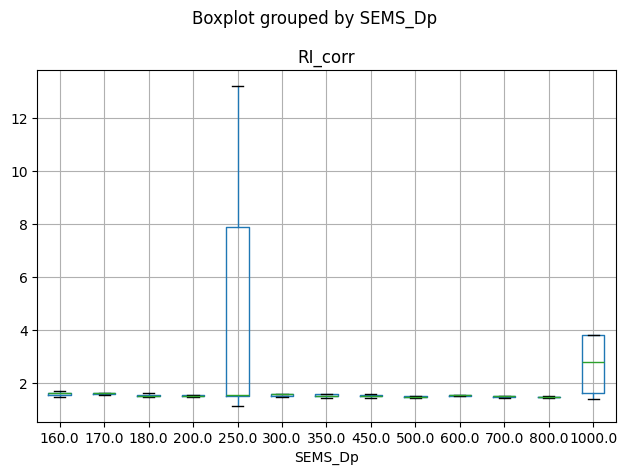

In [26]:
r.boxplot(column=['RI_corr'], by='SEMS_Dp', showfliers = False)
plt.tight_layout()
plt.savefig('../figures/boxplot.png', dpi=300)

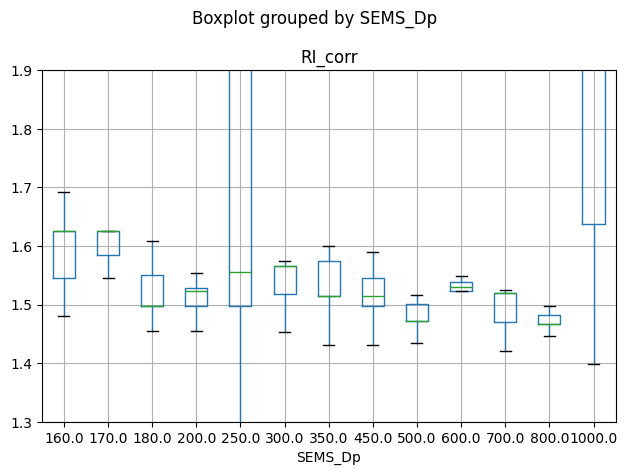

In [27]:
r.boxplot(column=['RI_corr'], by='SEMS_Dp', showfliers = False)
plt.ylim([1.3, 1.9])
plt.tight_layout()
plt.savefig('../figures/boxplot_lim.png', dpi=300)

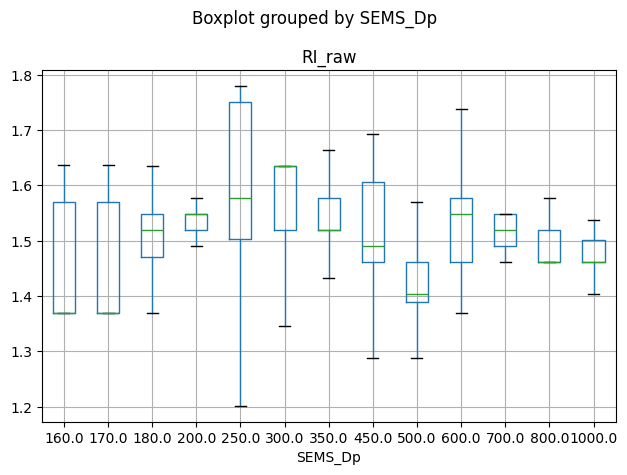

In [28]:
r.boxplot(column=['RI_raw'], by='SEMS_Dp', showfliers = False)
plt.tight_layout()
plt.savefig('../figures/boxplot_raw.png', dpi=300)

In [23]:
for i in range(0, len(r_dps)):
    D = str(int(r_dps[i].loc[0,'SEMS_Dp']))
    r_dps[i].hist(column=['GF_raw_'+D])
    plt.close()

In [28]:
def plot_alt_daily():
    max_alt, min_alt = np.linspace(500,7000, 14), np.linspace(0,6500, 14)
    GF_labels = ((max_alt+min_alt)/2).astype(int)
    min_dt, max_dt = [pd.to_datetime('2024-5-28'), pd.to_datetime('2024-6-06'), pd.to_datetime('2024-7-29')], [pd.to_datetime('2024-6-01'),pd.to_datetime('2024-6-14'), pd.to_datetime('2024-8-10')]
    for i in range(0, len(dps)):
        D = dps[i]
        dates = r_dps[i]['Start_Date_Time_UTC'].dt.date.unique()
        for j in range(0,len(dates)):
            fig, ax = plt.subplots(1,3,sharey=True, sharex=False)
            fig.suptitle('D$_p$ = ' + str(int(D)) + ', '+ str(dates[j]))

            sub = r_dps[i][r_dps[i]['Start_Date_Time_UTC'].dt.date == dates[j]]

            variables = ['GF_raw_'+str(int(D)), 'OMF', 'fRH550_RH20to80']
            for k in range(0,3):
                GF_len = []
                GF = []
                for l in range(0, len(min_alt)):
                    GF.append(sub[variables[k]][(sub['GPS_Altitude'] >= min_alt[l]) & (sub['GPS_Altitude'] < max_alt[l])].dropna())
                    GF_len.append(len(GF[l]))
                
                ax[k].boxplot(GF, tick_labels=GF_labels, vert = False, showfliers=False)

                ax[k].set_xlabel(variables[k])
            fig.savefig('../figures/' + str(dates[j]) + '_alt_daily_' + str(int(D)) +'.png', dpi=300)
            plt.close()

In [29]:
plot_alt_daily()